[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Showmick119/Benchmarking-Signal-Processing-Packages/blob/main/test/train_hrv_model.ipynb)

# **XGBoost Peak Classification - Model Training**
---
- **Repository: [Benchmarking-Signal-Processing-Packages](https://github.com/Showmick119/Benchmarking-Signal-Processing-Packages)**  
- **Author: Showmick Das**  
- **Purpose: Training a XGBoost classification model for HRV peak classification with GPU Acceleration**  
- **Created: June 2025**
---

This notebook trains an XGBoost Classification Model for peak classification using prepared participant datasets. It aims to classify which peaks in the dataset are True, and leverage those peaks for a more accurate estimate for the SDNN (HRV Metric).

**Purpose**: Leverage Colab GPUs for fast hyperparameter tuning and model iteration

**Steps:**
1. Setup Environment (Auto-detects Local Environment vs Google Colab)
2. Load training data from `model-data/participant_datasets/`
3. Train XGBoost model with hyperparameter tuning (Grid Search)
4. Save trained model and scaler
5. Display training results and analysis

**Environment-Specific Behavior:**
- **Local Mode**: Saves `.pkl` files directly to `test/` directory
- **Colab Mode**: Saves `.pkl` files and automatically downloads them for manual placement in repository

## **Setup**

In [ ]:
# FOR GOOGLE COLAB (uncomment when in Colab Environment):
!git clone https://github.com/Showmick119/Benchmarking-Signal-Processing-Packages.git
%cd Benchmarking-Signal-Processing-Packages/
!pip install xgboost scikit-learn matplotlib seaborn pandas numpy scipy
!pip install EMD-signal
!pip install wfdb
from google.colab import files

# FOR LOCAL TESTING (uncomment when in Local Environment):
# import os
# print(f"Current working directory: {os.getcwd()}")
# print("Running in local development mode")
# print("Make sure you have all required packages installed:")
# print("  - xgboost, scikit-learn, matplotlib, seaborn, pandas, numpy, scipy")

# Environment Detection
try:
    import google.colab
    IN_COLAB = True
    print("Google Colab environment detected")
except ImportError:
    IN_COLAB = False
    print("Local environment detected")

Current working directory: c:\Users\showm\OneDrive\Desktop\Benchmarking-Signal-Processing-Packages\test
Running in local development mode
Make sure you have all required packages installed:
  - xgboost, scikit-learn, matplotlib, seaborn, pandas, numpy, scipy
Local environment detected


## **Check GPU Availability**

In [ ]:
if IN_COLAB:
    !nvidia-smi

## **Import Dependencies & Initialize Classifier**

In [3]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

if IN_COLAB:
    from google.colab import files
    print("Google Colab files module imported for downloads")

current_dir = os.getcwd()
if 'test' in os.path.basename(current_dir):
    project_root = os.path.dirname(current_dir)
    if project_root not in sys.path:
        sys.path.append(project_root)
    print("Local environment (running from test/ directory)")
else:
    project_root = current_dir
    print("Colab environment (running from project root)")

print("Dependencies imported successfully")
print(f"Current working directory: {current_dir}")
print(f"Project root: {project_root}")

Local environment (running from test/ directory)
Dependencies imported successfully
Current working directory: c:\Users\showm\OneDrive\Desktop\Benchmarking-Signal-Processing-Packages\test
Project root: c:\Users\showm\OneDrive\Desktop\Benchmarking-Signal-Processing-Packages


## **Import and Initialize the Model**

In [4]:
from models.XGBoostClassifier import XGBoostPeakClassifier

classifier = XGBoostPeakClassifier()
print("XGBoost Peak Classifier initialized")
print(f"Feature names: {classifier.feature_names}")

XGBoost Peak Classifier initialized
Feature names: ['amplitude', 'prominence', 'width_half_prom', 'pulse_area', 'rise_time', 'decay_time', 'max_upslope', 'max_inflection', 'ibi_prev', 'ibi_next', 'ibi_ratio', 'local_variance', 'snr', 'freq_energy', 'wavelet_coef']


## **Load Training Data**

In [5]:
if 'test' in os.path.basename(os.getcwd()):
    data_path = "../model-data"
else:
    data_path = "model-data"

print(f"Loading training data from {data_path}/participant_datasets/...")
X, y = classifier.load_data(data_path)

print(f"\nTraining data loaded successfully")
print(f"Total samples: {X.shape[0]}")
print(f"Features per sample: {X.shape[1]}")
print(f"Class distribution: {np.sum(y == 1)} true peaks, {np.sum(y == 0)} false peaks")

Loading training data from ../model-data/participant_datasets/...
Loading data from: ../model-data\participant_datasets
Found 97 CSV files:
  - HRV102M_Finger_Anticipatory: 139 peaks
  - HRV102M_Finger_Baseline: 143 peaks
  - HRV102M_Finger_Mental_Stress: 147 peaks
  - HRV102M_Finger_Physical_Stress: 154 peaks
  - HRV102M_Finger_Relaxed: 159 peaks
  - HRV103M_Finger_Anticipatory: 154 peaks
  - HRV103M_Finger_Baseline: 134 peaks
  - HRV103M_Finger_Physical_Stress: 170 peaks
  - HRV103M_Finger_Relaxed: 130 peaks
  - HRV104M_Finger_Anticipatory: 161 peaks
  - HRV104M_Finger_Baseline: 201 peaks
  - HRV104M_Finger_Mental_Stress: 188 peaks
  - HRV104M_Finger_Physical_Stress: 176 peaks
  - HRV106M_Finger_Mental_Stress: 189 peaks
  - HRV106M_Finger_Physical_Stress: 252 peaks
  - HRV108M_Finger_Anticipatory: 179 peaks
  - HRV108M_Finger_Baseline: 167 peaks
  - HRV108M_Finger_Mental_Stress: 183 peaks
  - HRV108M_Finger_Physical_Stress: 187 peaks
  - HRV108M_Finger_Relaxed: 204 peaks
  - HRV113M_

## **Train the XGBoost Model**
- If needed, can change the value of the random_state variable.

In [6]:
trained_model = classifier.train(random_state=42)

Data splits:
  Training: 11429 samples (70.0%)
  Test: 4899 samples (30.0%)

Training the XGBoost Classifier with hyperparameter tuning...
This may take a couple minutes...
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


c:\Users\showm\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:31:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)



Test set metrics:
Accuracy: 0.984
Precision: 0.990
Recall: 0.992
F1 Score: 0.991


c:\Users\showm\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:2676: UserWarning: [12:31:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\showm\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:729: UserWarning: [12:31:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only b

## **Save Trained Model**

In [7]:
if IN_COLAB:
    print("Google Colab Mode: Saving and downloading model files...")

    model_filename = 'trained_xgboost_model.pkl'
    scaler_filename = 'feature_scaler.pkl'

    joblib.dump(classifier.model, model_filename)
    joblib.dump(classifier.scaler, scaler_filename)

    print(f"Model saved as: {model_filename}")
    print(f"Scaler saved as: {scaler_filename}")

    print("\nAuto-downloading files for manual placement in repository...")
    files.download(model_filename)
    files.download(scaler_filename)

    print("\nNEXT STEPS:")
    print("1. The .pkl files have been downloaded to your local machine")
    print("2. Manually place these files in the repository's test/ directory:")
    print("   - trained_xgboost_model.pkl → /test/trained_xgboost_model.pkl")
    print("   - feature_scaler.pkl → /test/feature_scaler.pkl")
    print("3. Commit and push the files to the repository")
    print("4. Now test_hrv_model.ipynb can load these trained models")

else:
    print("Local Mode: Saving files to test/ directory...")

    if 'test' in os.path.basename(os.getcwd()):
        model_filename = 'trained_xgboost_model.pkl'
        scaler_filename = 'feature_scaler.pkl'
    else:
        os.makedirs('test', exist_ok=True)
        model_filename = 'test/trained_xgboost_model.pkl'
        scaler_filename = 'test/feature_scaler.pkl'

    joblib.dump(classifier.model, model_filename)
    joblib.dump(classifier.scaler, scaler_filename)

    print(f"✓ Model saved as: {model_filename}")
    print(f"✓ Scaler saved as: {scaler_filename}")
    print("✓ Files ready for test_hrv_model.ipynb!")

print(f"\nTraining complete! Model ready for inference on unseen datasets.")

Local Mode: Saving files to test/ directory...
✓ Model saved as: trained_xgboost_model.pkl
✓ Scaler saved as: feature_scaler.pkl
✓ Files ready for test_hrv_model.ipynb!

Training complete! Model ready for inference on unseen datasets.


## **Training Results & Analysis**
- Display the best hyperparameters for the model, which were found using the Grid Search hyperparameter tuning technique.

In [8]:
print("Best Hyperparameters Found:")
print("="*40)
for param, value in classifier.best_params.items():
    print(f"{param}: {value}")

Best Hyperparameters Found:
colsample_bytree: 0.9
gamma: 0
learning_rate: 0.1
max_depth: 10
min_child_weight: 1
n_estimators: 200
scale_pos_weight: 1
subsample: 0.8


## **Display Test Set Performance**

In [9]:
y_test_pred = classifier.model.predict(classifier.X_test)

print("Test Set Performance Metrics:")
print("="*30)
print(f"Accuracy:  {accuracy_score(classifier.y_test, y_test_pred):.3f}")
print(f"Precision: {precision_score(classifier.y_test, y_test_pred):.3f}")
print(f"Recall:    {recall_score(classifier.y_test, y_test_pred):.3f}")
print(f"F1 Score:  {f1_score(classifier.y_test, y_test_pred):.3f}")

print(f"\nTest set size: {len(classifier.y_test)} samples")
print(f"True positives:  {np.sum((classifier.y_test == 1) & (y_test_pred == 1))}")
print(f"True negatives:  {np.sum((classifier.y_test == 0) & (y_test_pred == 0))}")
print(f"False positives: {np.sum((classifier.y_test == 0) & (y_test_pred == 1))}")
print(f"False negatives: {np.sum((classifier.y_test == 1) & (y_test_pred == 0))}")

Test Set Performance Metrics:
Accuracy:  0.984
Precision: 0.990
Recall:    0.992
F1 Score:  0.991

Test set size: 4899 samples
True positives:  4369
True negatives:  452
False positives: 44
False negatives: 34


## **Plot Confusion Matrix**

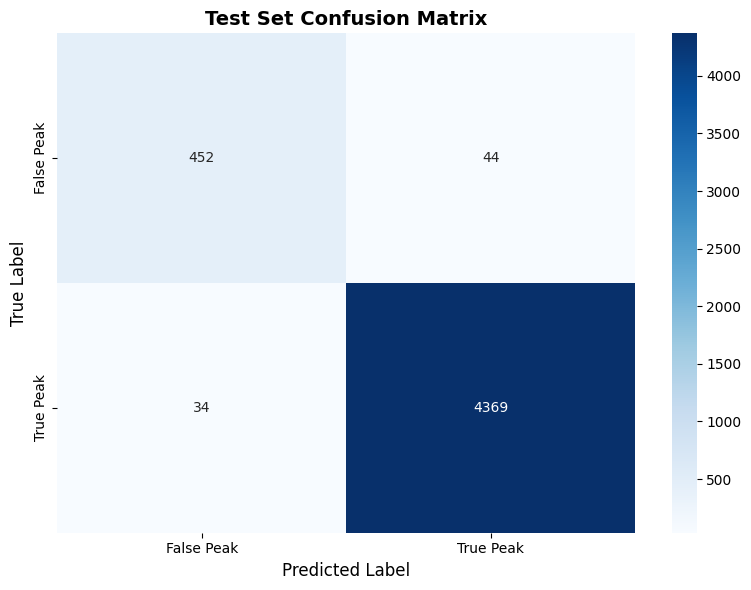

In [10]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(classifier.y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['False Peak', 'True Peak'],
            yticklabels=['False Peak', 'True Peak'])
plt.title('Test Set Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

## **Feature Importance Analysis**

C:\Users\showm\AppData\Local\Temp\ipykernel_33184\4281525587.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df, x='importance', y='feature', palette='viridis')


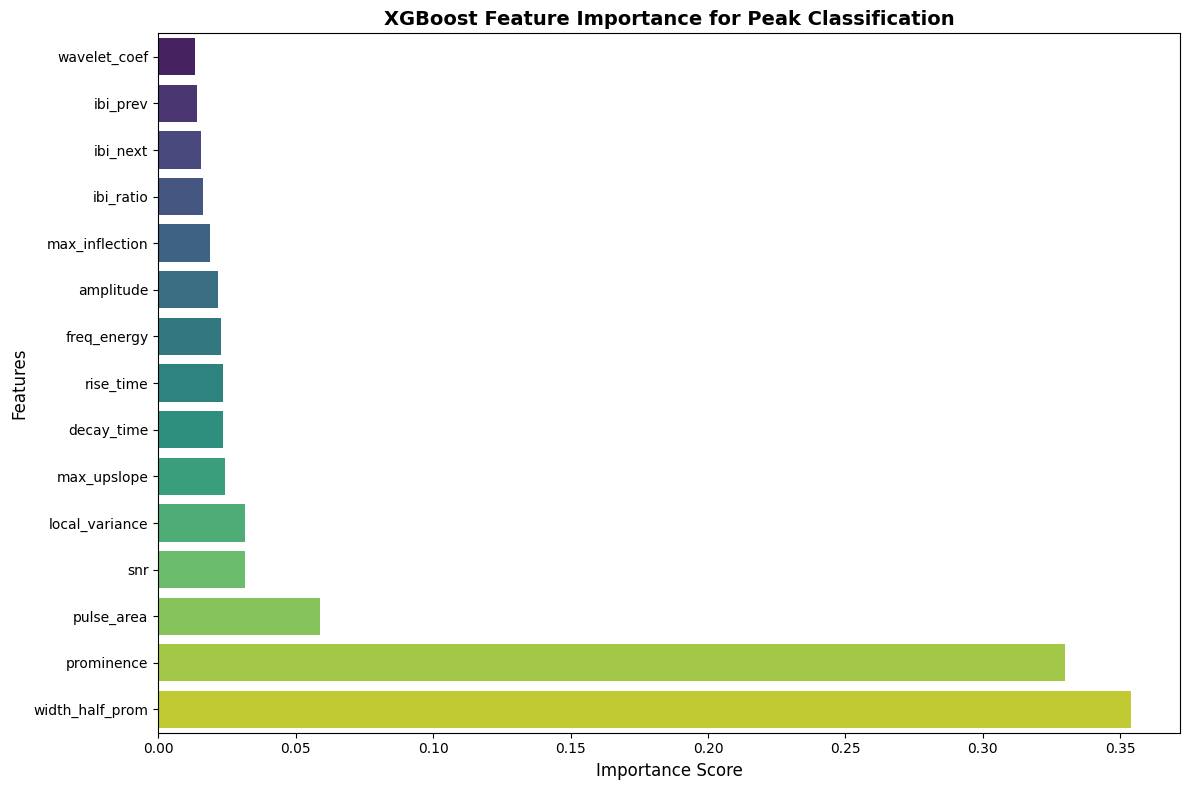


Top 10 Most Important Features:
 1. width_half_prom: 0.3540
 2. prominence     : 0.3300
 3. pulse_area     : 0.0588
 4. snr            : 0.0316
 5. local_variance : 0.0314
 6. max_upslope    : 0.0243
 7. decay_time     : 0.0235
 8. rise_time      : 0.0235
 9. freq_energy    : 0.0228
10. amplitude      : 0.0216


In [15]:
importance = classifier.model.feature_importances_

feature_df = pd.DataFrame({
    'feature': classifier.feature_names,
    'importance': importance
}).sort_values('importance', ascending=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_df, x='importance', y='feature', palette='viridis')
plt.title('XGBoost Feature Importance for Peak Classification', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print("="*35)
for i, (feature, imp) in enumerate(feature_df.tail(10)[['feature', 'importance']].values[::-1], 1):
    print(f"{i:2d}. {feature:15s}: {imp:.4f}")

## **SDNN Analysis on Training Datasets**

In [16]:
print("Running full SDNN analysis on training datasets...")
print("This shows how the model performs on the corrected training data.")
print("\nNote: These are the same datasets used for training, so this is not a test of generalization.")
print("The test notebook will evaluate performance on truly unseen data.")
print("\n" + "="*80)

results_list, comparison_data = classifier.run_full_analysis()

Running full SDNN analysis on training datasets...
This shows how the model performs on the corrected training data.

Note: These are the same datasets used for training, so this is not a test of generalization.
The test notebook will evaluate performance on truly unseen data.


Analyzing HRV102M_Finger_Anticipatory...
Signal Frequency = 130.001 Hz

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Calculated ECG SDNN for HRV102M_Finger_Anticipatory: 38.701 ms (139 peaks)
  Original peaks: 138
  Corrected peaks: 138
  Peaks removed: 0

Analyzing HRV102M_Finger_Baseline...
Signal Frequency = 130.001 Hz

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Calculated ECG SDNN for HRV102M_Finger_Baseline: 31.946 ms (142 peaks)
  Original peaks: 142
  Corrected peaks: 142
  Peaks remo

## **Training Summary**

In [19]:
print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"✓ Model trained on {len(classifier.dataset_info)} datasets")
print(f"✓ Total training samples: {len(classifier.X)}")
print(f"✓ Test accuracy: {accuracy_score(classifier.y_test, y_test_pred):.1%}")

if IN_COLAB:
    print(f"✓ Model files downloaded to your local machine")
    print("\nCOLAB WORKFLOW COMPLETE")
    print("Next Steps:")
    print("1. Files automatically downloaded from Colab")
    print("2. Manually place the .pkl files in your repo's test/ directory")
    print("3. Commit and push the files to your repository")
    print("4. Use test_hrv_model.ipynb for inference on unseen datasets")
else:
    print(f"✓ Model files saved locally: {model_filename}, {scaler_filename}")
    print("\nLOCAL WORKFLOW COMPLETE")
    print("Next Steps:")
    print("1. Files saved directly to your test/ directory")
    print("2. Commit and push the files to your repository")
    print("3. Use test_hrv_model.ipynb for inference on unseen datasets")

print("\nThe test notebook lets you select any dataset from all 4 subdirectories:")
print("   • HR_Lab_Data_Day_1_Mom (97 datasets)")
print("   • HR_Lab_Data_Day_1_Teen")
print("   • HR_Lab_Data_Day_2_Mom")
print("   • HR_Lab_Data_Day_2_Teen")
print("   Total: 470 datasets available for testing")


TRAINING COMPLETE
✓ Model trained on 97 datasets
✓ Total training samples: 16328
✓ Test accuracy: 98.4%
✓ Model files saved locally: trained_xgboost_model.pkl, feature_scaler.pkl

LOCAL WORKFLOW COMPLETE
Next Steps:
1. Files saved directly to your test/ directory
2. Commit and push the files to your repository
3. Use test_hrv_model.ipynb for inference on unseen datasets

The test notebook lets you select any dataset from all 4 subdirectories:
   • HR_Lab_Data_Day_1_Mom (97 datasets)
   • HR_Lab_Data_Day_1_Teen
   • HR_Lab_Data_Day_2_Mom
   • HR_Lab_Data_Day_2_Teen
   Total: 470 datasets available for testing
